In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from IPython.display import display, Math
from scipy.stats import multivariate_normal
import random
from scipy import optimize
import plotly.graph_objs as go
import numdifftools
import lmfit
import corner

In [2]:
def intensity(kinetic_energy, max_energy, Z):
    """spectrum function"""
    me = 0.511*1000 #keV
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)

def Fermi_function(Z, kinetic_energy):
    me = 0.511*1000 #keV
    a = 1/137
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    x = Z*a*E/pc
    return 2*np.pi*x/(1-np.exp(-2*np.pi*x))

In [3]:
def B(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2



def T(x, x_knots, b):
    """
    time strategy
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B(x, 3, i, t)
    
    return T

In [4]:
def experimental_lin(kinetic_energy, max_energy, noise, calibr, lin, Z=2, me=511):
    """
    function for fitting with linear additive
    """
    return calibr*(np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy) -lin*(max_energy - kinetic_energy)) + noise 

def intensity_lin(kinetic_energy, max_energy, ampl, Z=2, me=511):
    """
    function for intensity with linear additive
    """
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)-ampl*(max_energy - kinetic_energy)

In [5]:
max_energy = 18.57 
lin = 10 ** 4
n = 1000 # number of points
KEs = np.linspace(0.001, max_energy - 0.2, n) #kinetic energies 

#derivatives = np.array([div_max(KEs), np.ones(len(KEs)), div_cal(KEs), div_ampl(KEs)]) 
dist = intensity_lin(KEs, max_energy, lin) #intensity
a = 0 #start of grid
b = max_energy #end of grid
x_knots = np.concatenate([np.linspace(a-2, a-0.5, 3), np.linspace(a, b, 10), np.linspace(b + 1.5, b + 3.5, 3)])
b0 = np.ones(len(x_knots) - 6) #initial weights
bl = tuple(np.zeros(len(x_knots) - 6)) #lower bound
bw = tuple(np.ones(len(x_knots) - 6)*50) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [6]:
def log_likelihood(theta, KEs, y, time):
    max_energy, noise, calibr, lin = theta
    model = experimental_lin(KEs, max_energy, noise, calibr, lin)
    sigma = np.sqrt(model*time)/time
    return -0.5 * np.sum((y - model) ** 2 / sigma**2 + np.log(sigma**2))

In [7]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([max_energy, 0, 1, lin]) + 0.1 * np.random.randn(4)
soln = optimize.minimize(nll, initial, args=(KEs, y, time), method='Nelder-Mead', options={'maxfev':5000 ,'maxiter':5000})
max_energy_ml, noise_ml, calibr_ml, lin_ml = soln.x
print("Initial:")
print(*initial)
print("Maximum likelihood estimates:")
print(max_energy_ml, noise_ml, calibr_ml, lin_ml)

plt.errorbar(KEs, y, yerr=np.sqrt(dist*time)/time)
plt.plot(KEs, dist)
plt.plot(KEs, experimental_lin(KEs, *soln.x))

NameError: name 'y' is not defined

In [8]:
def log_multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return -0.5*(np.log((2 * np.pi)**d * np.linalg.det(covariance)) + np.linalg.solve(covariance, x_m).T.dot(x_m))

In [9]:
def log_prior(theta):
    #mean = np.array([[-1.], [0.], [0.]])  # Mean
    #covariance = np.array([
    #                    [0.5, 0.01, 0.01], 
    #                    [0.01, 50, 1],
    #                    [0.01, 1, 50]])  # Covariance
    #return log_multivariate_normal(theta, 3, mean, covariance)[0][0]
    max_energy, noise, calibr, lin = theta
    sigma = 97
    x_m = lin - 10**4
    return -0.5*(np.log(2 * np.pi * sigma**2) + (x_m/sigma)**2)
    
   # if 18.0 < max_energy < 19.0 and -100.0 < noise < 100.0 and 0. < calibr < 2.0 and 5000 < lin < 15000:
    #    return 0.0
    #return -np.inf

In [10]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [11]:
bo = [3.44899946, 0.        , 0.        , 0.        , 0.        ,
       1.31942577, 1.37361597, 0.        , 0.        , 0.36451806]

In [12]:
np.random.seed(42)
b = bo
time = np.array([T(x, x_knots, b) for x in KEs])
y0 = np.array([T(x, x_knots, b0) for x in KEs])
time = time * np.sum(y0) / np.sum(time)
y = np.random.poisson(dist*time)/time

In [17]:
%%time
np.random.seed(93284)
pos = np.array([max_energy, 0, 1, lin]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(KEs, y, time))
sampler.run_mcmc(pos, 10000, progress=True);

C:\ProgramData\Anaconda3\lib\site-packages\emcee\ensemble.py:255: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.58it/s]

Wall time: 43.4 s


State([[ 1.85698128e+01  7.75237811e+01  1.00011878e+00  1.00562450e+04]
 [ 1.85703701e+01  1.72348177e+01  1.00001178e+00  1.00307880e+04]
 [ 1.85699430e+01  5.85483108e+01  1.00018394e+00  1.00872424e+04]
 [ 1.85700783e+01 -9.57458698e+00  1.00000560e+00  1.00028624e+04]
 [ 1.85700035e+01  5.12127941e+01  1.00016032e+00  1.00731826e+04]
 [ 1.85702154e+01  6.12795498e+00  1.00009640e+00  1.00661364e+04]
 [ 1.85699842e+01  3.30495061e+01  1.00011114e+00  1.00480698e+04]
 [ 1.85699058e+01  3.05225161e+01  1.00006788e+00  1.00228348e+04]
 [ 1.85701590e+01  6.32972611e+01  1.00013398e+00  1.00835770e+04]
 [ 1.85700317e+01  3.30009931e+01  1.00021019e+00  1.00983939e+04]
 [ 1.85698539e+01  2.71659009e+01  1.00005890e+00  1.00076655e+04]
 [ 1.85701976e+01  4.51559765e+01  1.00016446e+00  1.01068192e+04]
 [ 1.85702144e+01 -6.68496030e+00  1.00014660e+00  1.00808480e+04]
 [ 1.85699402e+01  8.43349736e+01  9.99995569e-01  9.99304175e+03]
 [ 1.85698109e+01  7.08929319e+01  1.00012882e+00  1.006

Text(0.5, 0, 'step number')

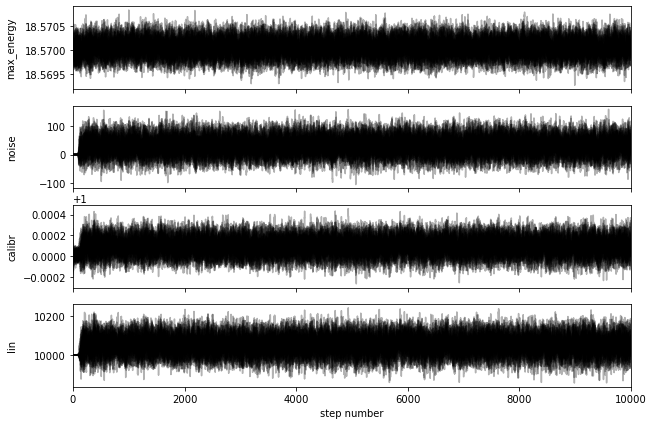

In [18]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["max_energy", "noise", "calibr", "lin"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
#plt.savefig("traces_uniform.png", dpi=300)

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

[46.59790448 45.20425249 47.23777328 48.75183386]
(20672, 4)


In [20]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

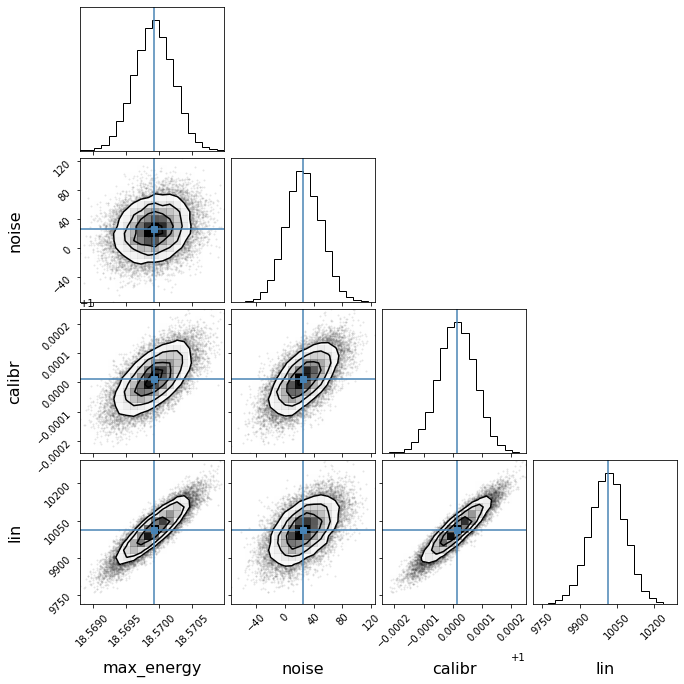

In [32]:
centers = np.zeros(ndim)
for i in range(ndim):
    centers[i] = np.percentile(flat_samples[:, i], [16, 50, 84])[1]

emcee_corner = corner.corner(flat_samples,labels=labels, truths=centers,
                            label_kwargs={"fontsize": 16}, labelpad=0.1)


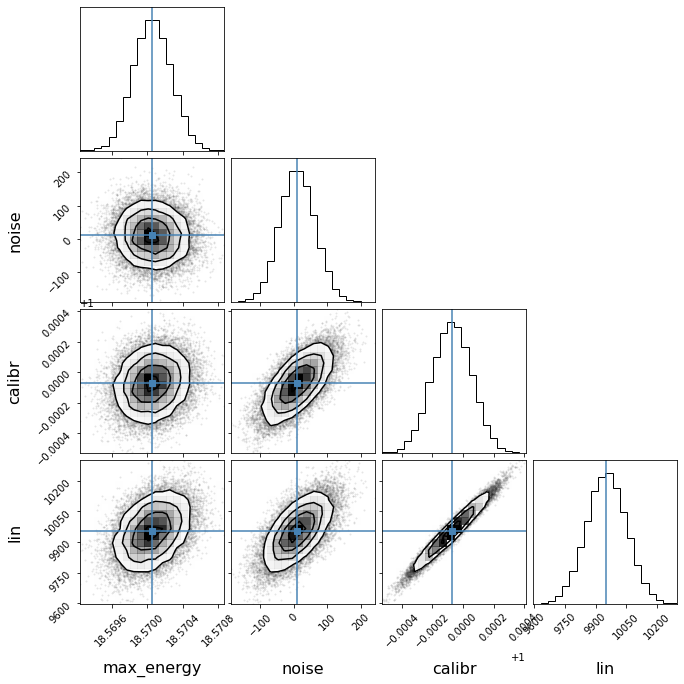

In [39]:
centers = np.zeros(ndim)
for i in range(ndim):
    centers[i] = np.percentile(flat_samples[:, i], [16, 50, 84])[1]

emcee_corner = corner.corner(flat_samples,labels=labels, truths=centers,
                            label_kwargs={"fontsize": 16}, labelpad=0.1)

In [45]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [181]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>